# a ) imports and data

In [1]:
import torch
import torch.nn.functional as f
import matplotlib.pyplot as plt
from collections import OrderedDict

from torch import nn
from torch import tensor
import torch.optim as optim
import torchvision
from torchvision.transforms import Compose, Resize, ToTensor,transforms
from torch.utils.data import DataLoader


In [2]:
from vit import visionTransformer
from my_utils.Trainer_module import Trainer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# prepare data
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
                                )


big_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# train_val split
trainset, valset = torch.utils.data.random_split(big_trainset, [45000, 5000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)



Files already downloaded and verified
Files already downloaded and verified


In [4]:
# dummy trainset for testing
trainset = torch.utils.data.Subset(trainset, range(500))
valset = torch.utils.data.Subset(valset, range(50))

In [5]:
# check label 
image,label = trainset[5]
print(label)

3


# b) exp1



In [13]:
model = visionTransformer(token_dim=48,
                          patch_size=4,
                          image_size=32,
                          n_attention_layers=4,
                          multihead_attention_head_dim=48,
                          multihead_attention_n_heads=8,
                          multilayer_perceptron_hidden_dim=512,
                          dropout_p=0.1,
                          n_classes=10).to(device)


In [14]:
#optimizer and loss function

optimizer =optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

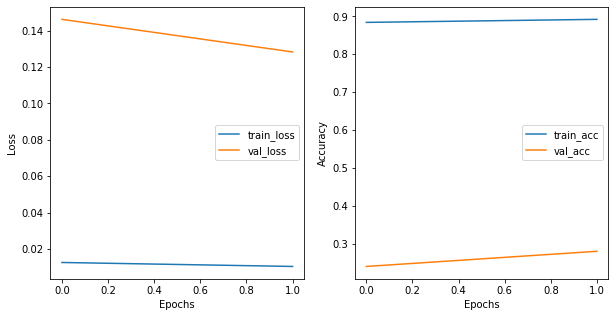

In [27]:
trainer = Trainer(model,optimizer,criterion,trainset,valset,testset,device,batch_size=32)
trainer.train(2)
trainer.plot( save_path="plots/b/", filename="exp_1.png")

# save model 
trainer.save_model( save_path='model_zoo/', filename='exp_1.pth')

# del model


# c) patch sizes

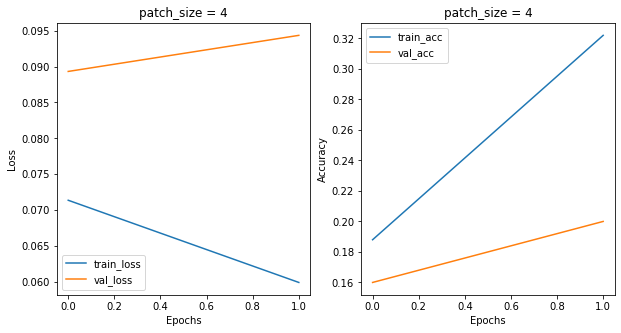

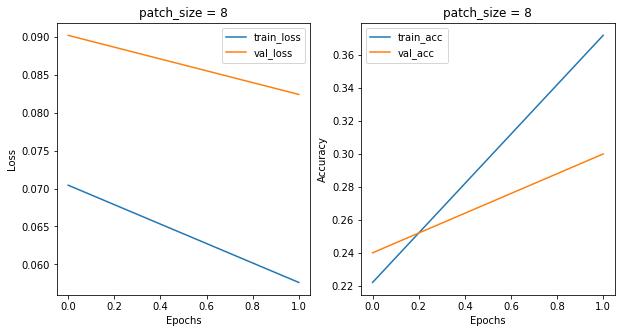

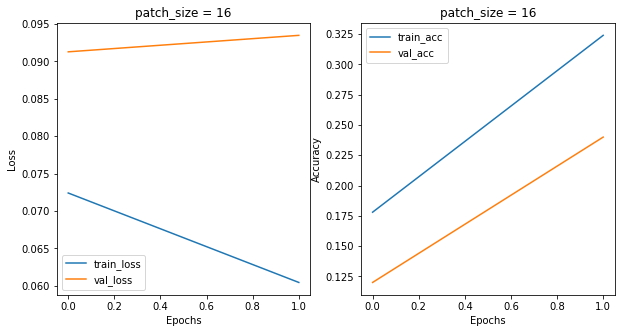

In [28]:
""" 
c) [Experiment 2] Try out different patch sizes (like 4x4, 8x8, 16x16). You
can divide the image into both overlapping and non-overlapping
patches.
""" 

for patch_size in [4,8,16]:
    model = visionTransformer(token_dim=48,
                              patch_size=patch_size,
                              image_size=32,
                              n_attention_layers=4,
                              multihead_attention_head_dim=48,
                              multihead_attention_n_heads=8,
                              multilayer_perceptron_hidden_dim=512,
                              dropout_p=0.1,
                              n_classes=10).to(device)

    #optimizer and loss function
    optimizer =optim.Adam(model.parameters(),lr=0.001)
    criterion = nn.CrossEntropyLoss()

    trainer = Trainer(model,optimizer,criterion,trainset,valset,testset,device,batch_size=32)
    trainer.train(2)
    trainer.plot( title="patch_size = {}".format(patch_size), save_path="plots/c/", filename="exp_2_patch_size_{}.png".format(patch_size))




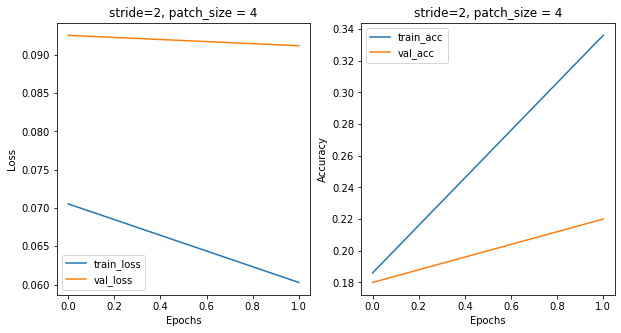

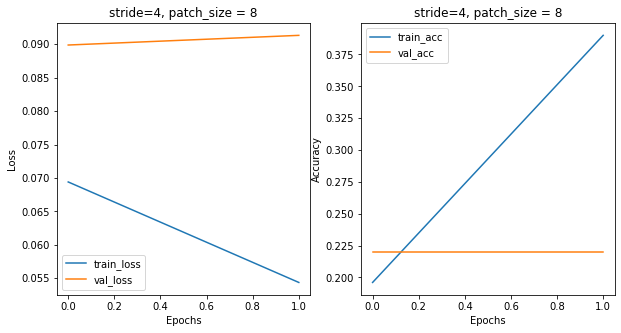

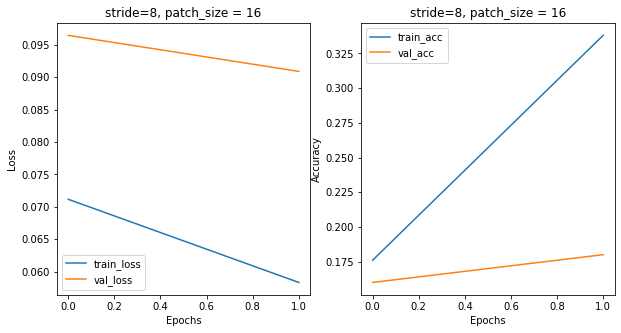

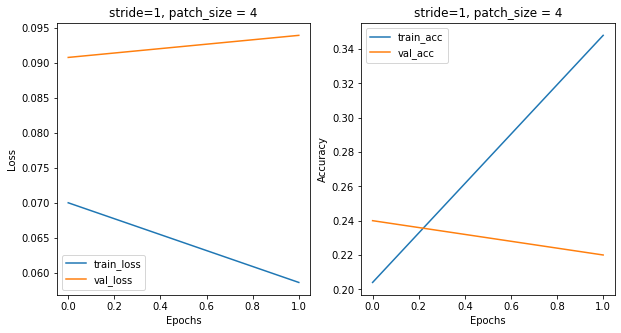

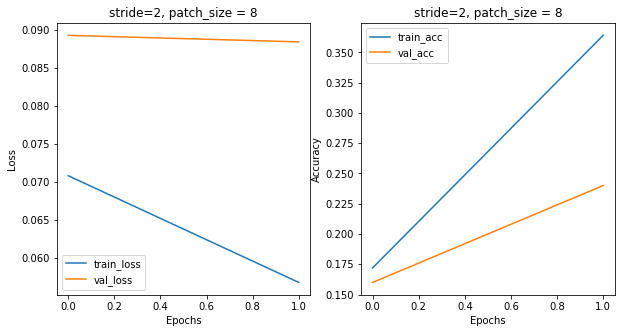

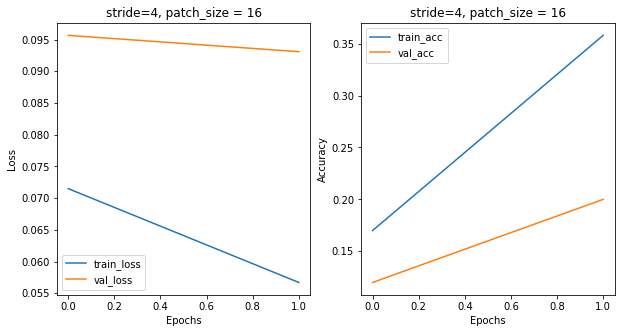

In [32]:
# with overlapping patches
#----------------------------------------------------------------------------------------

for OVERLAP in [2,4]:
    for patch_size in [4,8,16]:
        STRIDE = patch_size//OVERLAP
        
        # with 1/2 stride
        model = visionTransformer(token_dim=48,
                                patch_size=patch_size,
                                image_size=32,
                                n_attention_layers=4,
                                multihead_attention_head_dim=48,
                                multihead_attention_n_heads=8,
                                multilayer_perceptron_hidden_dim=512,
                                dropout_p=0.1,
                                n_classes=10,
                                stride_in_tokenization = STRIDE            #for overlapping patches
                                ).to(device)


        #optimizer and loss function
        optimizer =optim.Adam(model.parameters(),lr=0.001)
        criterion = nn.CrossEntropyLoss()

        trainer = Trainer(model,optimizer,criterion,trainset,valset,testset,device,batch_size=32,shuffle=False)
        trainer.train(2)
        trainer.plot( title=f"stride={STRIDE}, patch_size = {patch_size}", save_path="plots/c/", filename=f"exp_2_patch_size_{patch_size}_stride{STRIDE}.png")


# d) number of attention heads

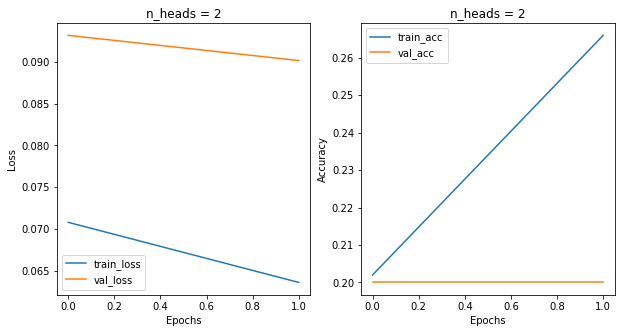

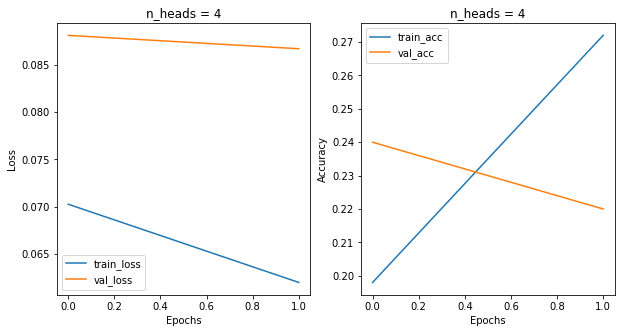

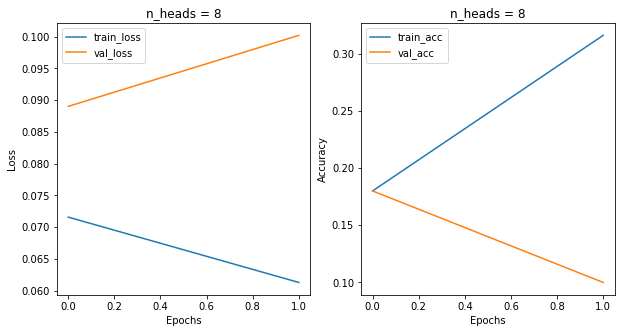

In [33]:
# with diffent number of heads 
for n_heads in [2,4,8]:
    model = visionTransformer(token_dim=48,
                              patch_size=4,
                              image_size=32,
                              n_attention_layers=4,
                              multihead_attention_head_dim=48,
                              multihead_attention_n_heads=n_heads,                  # for different number of heads
                              multilayer_perceptron_hidden_dim=512,
                              dropout_p=0.1,
                              n_classes=10).to(device)

    #optimizer and loss function
    optimizer =optim.Adam(model.parameters(),lr=0.001)
    criterion = nn.CrossEntropyLoss()

    trainer = Trainer(model,optimizer,criterion,trainset,valset,testset,device,batch_size=32)
    trainer.train(2)
    trainer.plot( title="n_heads = {}".format(n_heads), save_path="plots/d/", filename="exp_3_n_heads_{}.png".format(n_heads))
    del model

# e) cls from different layers


In [35]:
# to take last 
model = visionTransformer(token_dim=48,
                          patch_size=4,
                          image_size=32,
                          n_attention_layers=4,
                          multihead_attention_head_dim=48,
                          multihead_attention_n_heads=8,
                          multilayer_perceptron_hidden_dim=512,
                          dropout_p=0.1,
                          n_classes=10).to(device)

criterion = nn.CrossEntropyLoss()

# load the model 
model.load_state_dict(torch.load("model_zoo/exp_1.pth"))



<All keys matched successfully>

In [36]:
# test with tokens from different layers

# ------------------------------------
N_LAYERS = 4
loss_list = [0 for i in range(N_LAYERS)]
acc_list = [0 for i in range(N_LAYERS)]


test_loader = trainer.create_data_loader(testset) # using trainer from last experiment to keep the same batch size
model.eval()

for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        list_of_logits = model(images,return_cls_tokens_after_each_layer=True) #(4, torch.Size([32, 10]))
        for j,logits in enumerate(list_of_logits):
            loss_list[j] += criterion(logits, labels).item()
            acc_list[j] += (logits.argmax(dim=1) == labels).sum().item()
# devide with size of testset
loss_list = [loss/len(testset) for loss in loss_list]
acc_list = [acc/len(testset) for acc in acc_list]

        


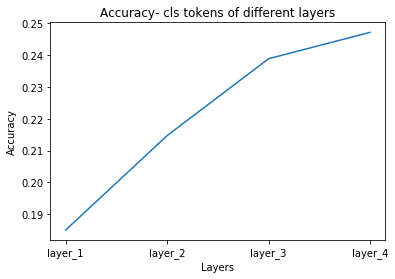

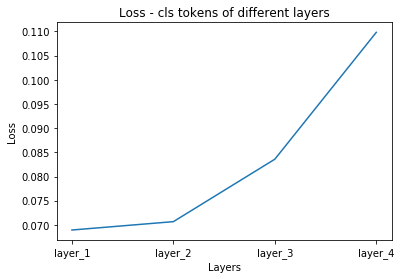

In [38]:
#bar plot using matplotlib
plt.plot(["layer_{}".format(i+1) for i in range(N_LAYERS)],acc_list)
plt.title("Accuracy- cls tokens of different layers")
plt.ylabel("Accuracy")
plt.xlabel("Layers")

# save plot
plt.savefig("plots/e/exp_4_acc.png")
plt.show()

# for loss plot
plt.plot(["layer_{}".format(i+1) for i in range(N_LAYERS)],loss_list)
plt.title("Loss - cls tokens of different layers")
plt.ylabel("Loss")
plt.xlabel("Layers")

# save plot
plt.savefig("plots/e/exp_4_loss.png")
plt.show()